# Feature lab

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
dataset_path = "../datasets/1.0v/"

In [4]:
!ls ../datasets/1.0v

Features.pdf  infos.csv  items.csv  orders.csv	README.md  Task_2020.pdf


## Loading our datasets...

In [5]:
infos = pd.read_csv(dataset_path + 'infos.csv', sep='|')
items = pd.read_csv(dataset_path + 'items.csv', sep='|')
orders = pd.read_csv(dataset_path + 'orders.csv', sep='|')

## FIle heads

In [6]:
orders.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19


In [7]:
items.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92
2,3,0,3,5.00,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04


In [8]:
infos.head()

,itemID,simulationPrice,promotion
0,1,3.43,NaN
1,2,9.15,NaN
2,3,14.04,NaN
3,4,14.10,NaN
4,5,7.48,NaN


## Basic stats

**Conclusion**: Our items have a high ```simulationPrice``` standard deviation, which affects directly our approach.

In [9]:
infos.describe().round(1)

,itemID,simulationPrice
count,10463.0,10463.0
mean,5232.0,122.0
std,3020.6,469.7
min,1.0,0.4
25%,2616.5,9.0
50%,5232.0,23.8
75%,7847.5,63.1
max,10463.0,9055.1


In [10]:
items.describe().round(1)

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
count,10463.0,10463.0,10463.0,10463.0,10463.0,10463.0,10463.0,10463.0
mean,5232.0,56.1,115.7,1.4,4.2,22.5,4.1,118.3
std,3020.6,76.0,77.3,2.1,2.5,14.9,2.5,339.3
min,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.5
25%,2616.5,0.0,47.0,0.0,2.0,8.0,2.0,14.0
50%,5232.0,0.0,107.0,0.0,4.0,23.0,4.0,24.2
75%,7847.5,101.0,173.0,4.0,7.0,38.0,7.0,67.9
max,10463.0,274.0,253.0,5.0,8.0,52.0,8.0,6955.0


In [11]:
orders.describe().round(1)

,transactID,itemID,order,salesPrice
count,2181955.0,2181955.0,2181955.0,2181955.0
mean,1073262.0,5247.7,1.2,36.7
std,631257.8,2454.6,0.7,126.1
min,1.0,1.0,1.0,0.0
25%,531377.5,3605.0,1.0,7.1
50%,1065659.0,5200.0,1.0,16.7
75%,1600669.5,7314.0,1.0,34.6
max,2294042.0,10463.0,100.0,9387.0


### Extracting the dates of promotion

This may be useful later on the competition. For now, let's just understand we have access to this data.

In [12]:
promotions = infos['promotion'].value_counts()
infos['promotion'].unique()

array([nan, '2018-07-13', '2018-07-01,2018-07-02,2018-07-13',
       '2018-07-05,2018-07-11', '2018-07-05', '2018-07-01', '2018-07-04',
       '2018-07-08', '2018-07-08,2018-07-13', '2018-07-09', '2018-06-30',
       '2018-07-11', '2018-07-06', '2018-07-08,2018-07-11',
       '2018-06-30,2018-07-13', '2018-06-30,2018-07-01,2018-07-11',
       '2018-07-06,2018-07-13', '2018-07-06,2018-07-10', '2018-07-10',
       '2018-07-08,2018-07-10', '2018-06-30,2018-07-04',
       '2018-07-01,2018-07-10', '2018-07-02', '2018-06-30,2018-07-01',
       '2018-07-04,2018-07-05,2018-07-06', '2018-07-04,2018-07-05',
       '2018-07-01,2018-07-06', '2018-06-30,2018-07-06',
       '2018-07-05,2018-07-13', '2018-07-01,2018-07-02', '2018-07-03',
       '2018-07-03,2018-07-04,2018-07-05',
       '2018-07-03,2018-07-04,2018-07-06', '2018-07-03,2018-07-04',
       '2018-07-03,2018-07-05', '2018-07-04,2018-07-09',
       '2018-07-04,2018-07-06', '2018-07-02,2018-07-04', '2018-07-12',
       '2018-07-02,2018-07-0

### Removing the items that were never sold

In [13]:
# Taking the ids of the items that were sold at least once...
sold_items_id = orders['itemID'].unique()
sold_items_id

array([ 450,   83, 7851, ..., 6427, 8604, 9796])

In [119]:
# Items that were sold at least once will be stored in 'sold_items'
sold_items = items[items.itemID.isin(sold_items_id)]
sold_items

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92
2,3,0,3,5.00,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04
...,...,...,...,...,...,...,...,...
10449,10450,182,227,0.00,8,44,8,36.78
10458,10459,180,253,0.00,8,44,8,56.57
10459,10460,0,253,0.00,8,44,8,163.81
10461,10462,180,253,0.00,8,44,8,166.97


Just making a sanity check to be sure if we really have kept only the items that had been sold at least once...

In [15]:
fact_check = np.array(sold_items.itemID)
fact_check == sorted(sold_items_id)

array([ True,  True,  True, ...,  True,  True,  True])

In [16]:
# We'll extract only the infos about the items that were sold at least once...
sold_infos = infos[infos.itemID.isin(sold_items_id)]
sold_infos

,itemID,simulationPrice,promotion
0,1,3.43,NaN
1,2,9.15,NaN
2,3,14.04,NaN
3,4,14.10,NaN
4,5,7.48,NaN
...,...,...,...
10449,10450,44.43,2018-07-10
10458,10459,14.71,NaN
10459,10460,325.67,NaN
10461,10462,304.30,NaN


Another sanity check...

In [17]:
fact_check_2 = np.array(sold_infos.itemID)
fact_check_2 == sorted(sold_items_id)

array([ True,  True,  True, ...,  True,  True,  True])

### <span style="color:red">Most revenue items</span>

It's very strange that some items are sold below the 'recommended retail price'

In [57]:
# Concatenating the itemID column with the revenue column...
sold_items_revenue = pd.DataFrame(pd.concat([sold_items.itemID, sold_infos.simulationPrice -  sold_items.recommendedRetailPrice], axis=1, names=['itemID', 'revenue']))

In [60]:
items_revenue = pd.concat([items.itemID, infos.simulationPrice -  items.recommendedRetailPrice], axis=1, names=['itemID', 'revenue'])
items_revenue

,itemID,0
0,1,-5.41
1,2,-7.77
2,3,-1.85
3,4,-26.07
4,5,-9.56
...,...,...
10458,10459,-41.86
10459,10460,161.86
10460,10461,62.52
10461,10462,137.33


### Demystifying the categories

Ordering the items by how much they were sold and displaying it's categories (the first position has the id of the most sold item, and so goes on).

In [181]:
category = items[['itemID','category1','category2','category3']]
category_and_orders = pd.merge(orders, category, on='itemID')
category_and_orders_stats = category_and_orders.groupby('itemID').aggregate({'order' : ['sum','count'],'category1': ['mean'], 'category2': ['mean'], 'category3': ['mean']})
category_and_orders_stats = category_and_orders_stats.sort_values(('order', 'sum'), ascending=False)
category_and_orders_stats

order       category1 category2 category3
          sum count      mean      mean      mean
itemID                                           
7789    12184  7415         4        39         7
5035    11908  8973         5        21         4
5117     9100  8063         5        21         4
4297     8675  3128         6        18         3
5039     8444  4433         5        28         4
...       ...   ...       ...       ...       ...
2983        1     1         2        10         2
2981        1     1         2         9         2
2969        1     1         2         9         2
6900        1     1         7        24         6
10463       1     1         8        44         8

[9840 rows x 5 columns]

#### How well distribuited are the categories in the orders?

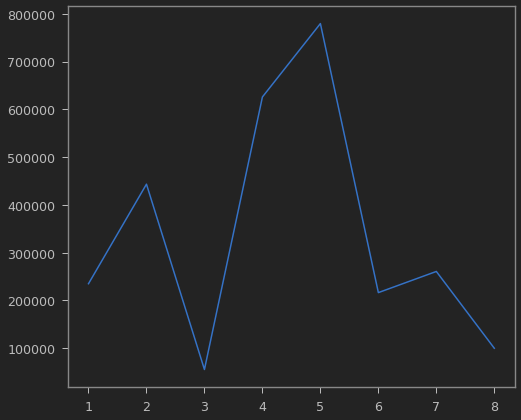

In [178]:
cat1_order_amount = category_and_orders.groupby('category1').aggregate({'order' : ['sum']})
cat1_order_amount.sort_values(('order', 'sum'), ascending=False)
plt.plot(cat1_order_amount)

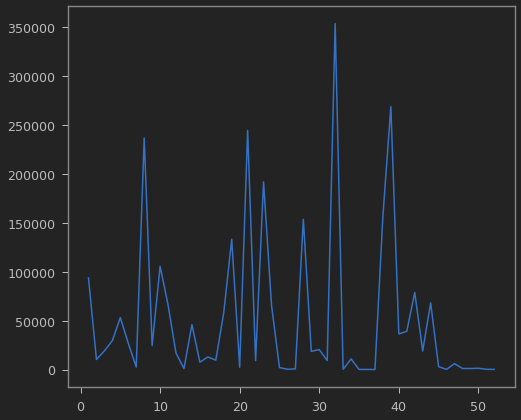

In [179]:
cat2_order_amount = category_and_orders.groupby('category2').aggregate({'order' : ['sum']})
cat2_order_amount.sort_values(('order', 'sum'), ascending=False)
plt.plot(cat2_order_amount)

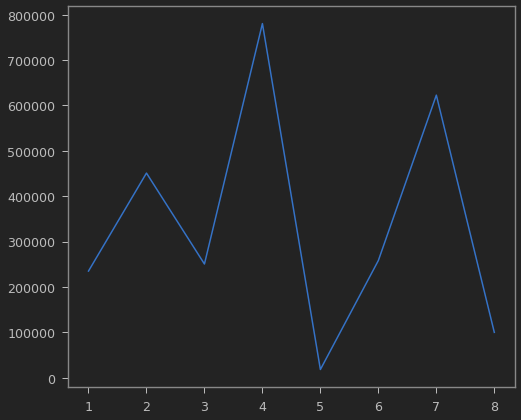

In [180]:
cat3_order_amount = category_and_orders.groupby('category3').aggregate({'order' : ['sum']})
cat3_order_amount.sort_values(('order', 'sum'), ascending=False)
plt.plot(cat3_order_amount)

### Customer rating evaluation

Almost 70% of our customer ratings consist of zeros, <span style="color:red">so this feature might not be as useful as I expected at first glance</span>

67.19512195121952%


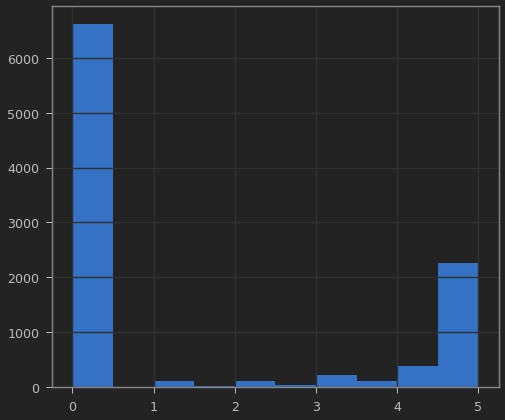

In [115]:
sold_items.customerRating.hist()
print(f'{len(sold_items.customerRating[sold_items.customerRating == 0])/len(sold_items) * 100}%')